In [1]:
from src.parse_folder import process_all_raw_recursive

_ = process_all_raw_recursive(
    raw_root="data/raw",
    meta_root="data/metadata",
    schema="configs/procedures.yml",
    overwrite=True,
    make_timeline=True,
    verbose=True,
)

[discover] raw_root=/home/mphstphls/python-lab/data/raw dirs_with_csv=692
[process] /home/mphstphls/python-lab/data/raw/LabComputer1/data/2023-06-09
[parse_folder] base_dir=/home/mphstphls/python-lab/data/raw/LabComputer1/data/2023-06-09 csvs_found=5
[parse_header] IVg2023-06-09_13.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_14.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_16.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_17.csv: proc=IVg start_time=315543600.0 fields=21
[parse_header] IVg2023-06-09_18.csv: proc=IVg start_time=315543600.0 fields=21
[ok] wrote /home/mphstphls/python-lab/data/metadata/LabComputer1/data/2023-06-09/metadata.csv rows=5
[process] /home/mphstphls/python-lab/data/raw/LabComputer1/data/2023-06-13
[parse_folder] base_dir=/home/mphstphls/python-lab/data/raw/LabComputer1/data/2023-06-13 csvs_found=9
[parse_header] IVg2023-06-13_1.csv: proc=IVg start_time=315543600.0 fields=2

In [2]:
from src.db_build import build_warehouse, build_timeline_dataset

build_warehouse(meta_root="data/metadata", out_root="warehouse", overwrite=True, verbose=True)
build_timeline_dataset(meta_root="data/metadata", out_root="warehouse", overwrite=True, verbose=True)


[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-04/part-0.parquet rows=46
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-07/part-0.parquet rows=33
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-08/part-0.parquet rows=24
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-09/part-0.parquet rows=8
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-16/part-0.parquet rows=36
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-17/part-0.parquet rows=87
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-22/part-0.parquet rows=14
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-25/part-0.parquet rows=39
[ok] wrote /home/mphstphls/python-lab/warehouse/experiments/LabComputer3/data/2025-04-28/part-0.parquet r

shape: (5, 3)
┌─────────────────────┬──────┬─────┐
│ day                 ┆ proc ┆ n   │
│ ---                 ┆ ---  ┆ --- │
│ datetime[μs]        ┆ str  ┆ u32 │
╞═════════════════════╪══════╪═════╡
│ 1980-01-01 00:00:00 ┆ ?    ┆ 3   │
│ 1980-01-01 00:00:00 ┆ IV   ┆ 73  │
│ 1980-01-01 00:00:00 ┆ IVg  ┆ 244 │
│ 1980-01-01 00:00:00 ┆ It   ┆ 10  │
│ 1980-01-01 00:00:00 ┆ IVgT ┆ 2   │
└─────────────────────┴──────┴─────┘


/tmp/ipykernel_22712/2014364571.py:20: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  counts.pivot(


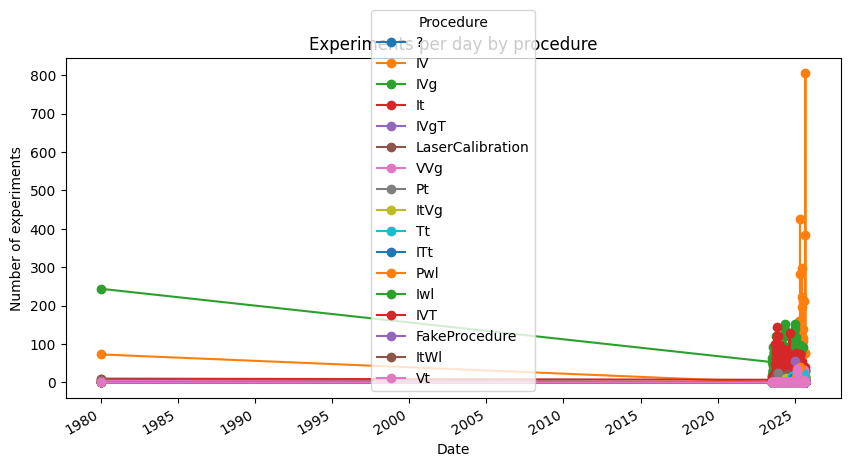

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import datetime
# Scan all parquet partitions recursively
lf = pl.scan_parquet("warehouse/experiments/**/part-*.parquet", extra_columns="ignore")

counts = (
    lf.with_columns(pl.col("start_dt").dt.truncate("1d").alias("day"))
      .filter(pl.col("day") >= dt.datetime(2023, 1, 1))   # 👈 filter here
      .group_by(["day", "proc"])
      .agg(pl.len().alias("n"))
      .sort("day")
      .collect()
)

print(counts.head())

# Pivot to wide for plotting
pivot = (
    counts.pivot(
        values="n",
        index="day",
        columns="proc",
        aggregate_function="sum",
    )
    .fill_null(0)
    .sort("day")
)

# Extract x (datetime) and series
x = pivot.get_column("day").to_list()
procs = [c for c in pivot.columns if c != "day"]
series_by_proc = {p: pivot.get_column(p).to_list() for p in procs}

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

for p in procs:
    ax.plot(x, series_by_proc[p], marker="o", label=p)

ax.set_xlabel("Date")
ax.set_ylabel("Number of experiments")
ax.set_title("Experiments per day by procedure")
ax.legend(title="Procedure")
fig.autofmt_xdate()  # rotate/format datetime ticks nicely
plt.show()
